In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, balanced_accuracy_score, recall_score, precision_score
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from utils.loading import load_data, read_annot, load_raw_data, append_detections
from utils.processing import get_fft, plot_stft, get_stft, resample_signal, bandpass_filter, SNR_comp
from utils.features_generator import compute_features, generate_features
import pandas as pd

### Data loading

In [3]:
%%capture
raws = load_raw_data()

In [4]:
raws[2].ch_names[:10]

['ECG',
 'FP1-A1',
 'CZ-A1',
 'EMG1',
 'EOG1-A1',
 'VTH',
 'VAB',
 'NAF2P-A1',
 'NAF1',
 'PHONO']

#### Frequencies

In [5]:
freqs = [100] + [raws[i].info['sfreq'] for i in range(2, 9)]
freqs

[100, 200.0, 50.0, 200.0, 200.0, 200.0, 200.0, 200.0]

In [6]:
%%capture
signals, detections_1, detections_2 = load_data()

### Synchronization

In [7]:
sampling_freq = 200
resampled = {}

for i in range(1, 9):
    res = resample_signal(signals[i].values.flatten(), freqs[i-1], sampling_freq)
    resampled[i] = pd.DataFrame(res, columns=["y"])

In [8]:
for i in range(1, 9):
    print(len(signals[i]), len(resampled[i]), (np.arange(0, len(resampled[i])) / sampling_freq)[-1])

180000 359998 1799.985
360000 360000 1799.995
90000 359996 1799.975
360000 360000 1799.995
360000 360000 1799.995
360000 360000 1799.995
360000 360000 1799.995
360000 360000 1799.995


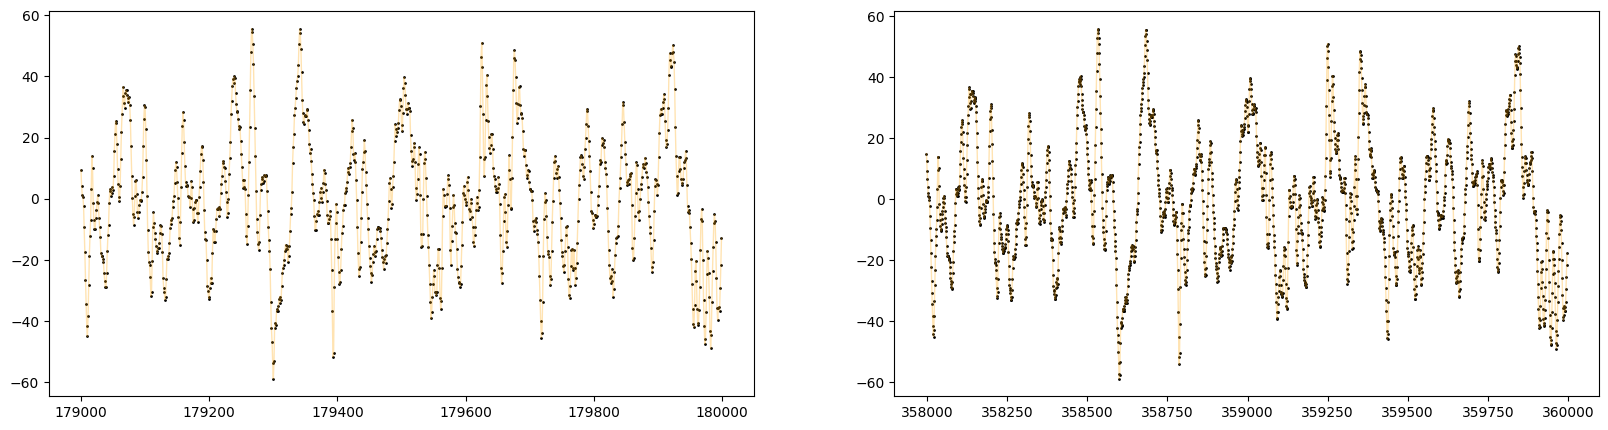

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))

freqs[0]
axs[0].scatter(signals[1][-10*freqs[0]:].index, signals[1][-10*freqs[0]:], s=1, c="k") # 10 seconds
axs[0].plot(signals[1][-10*freqs[0]:], linewidth=1, c='orange', alpha=0.3)

axs[1].scatter(resampled[1][-10*sampling_freq:].index, resampled[1][-10*sampling_freq:], s=1, c="k")
axs[1].plot(resampled[1][-10*sampling_freq:], linewidth=1, c='orange', alpha=0.3);

### Filtering

In [10]:
freqs, magns = get_fft(resampled[1].values.flatten(), sampling_freq)
freqs_filt, magns_filt = get_fft(bandpass_filter(resampled[1].values.flatten(), 0.3, 35, sampling_freq, 4), sampling_freq)

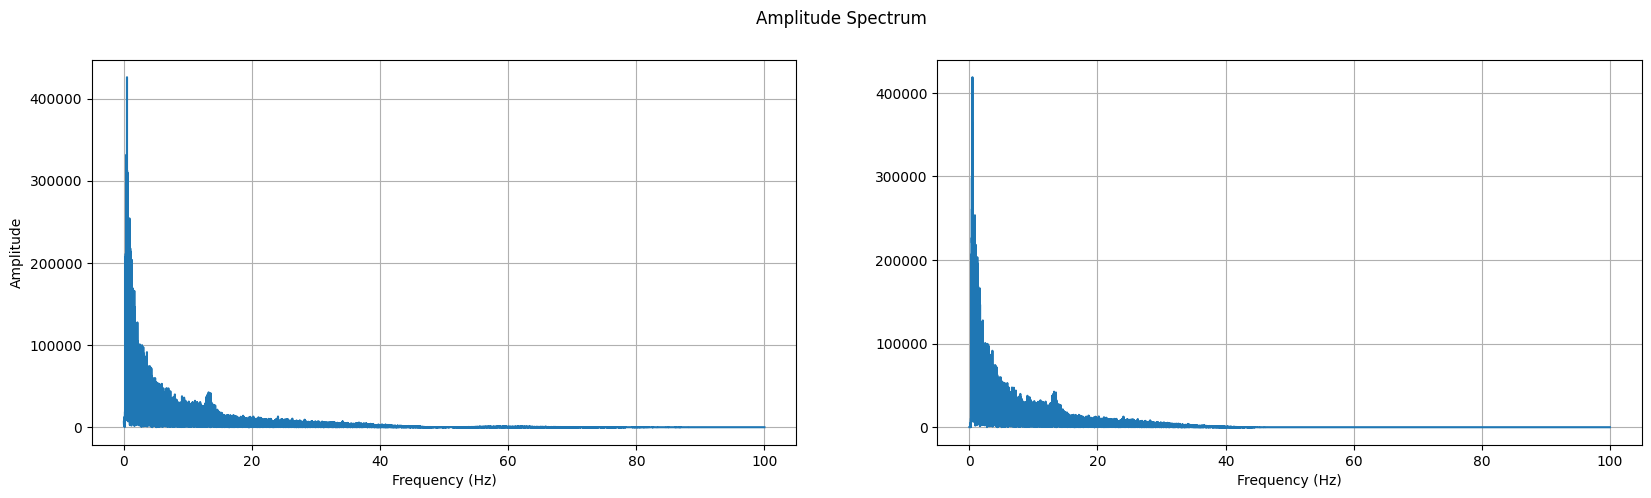

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))

axs[0].plot(freqs, magns)
axs[1].plot(freqs_filt, magns_filt)

fig.suptitle('Amplitude Spectrum')
axs[0].set_xlabel('Frequency (Hz)')
axs[1].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)
axs[1].grid(True)

In [12]:
snrs = []
snrs_filtered = []

for i in range(1, 9):
    y = signals[i].values.flatten()
    filt = bandpass_filter(y, 0.3, 35, sampling_freq, 4)
    snrs.append(SNR_comp(y, sampling_freq, 0, len(y)-1))
    snrs_filtered.append(SNR_comp(filt, sampling_freq, 0, len(filt)-1))

In [13]:
snr_df = pd.DataFrame(np.vstack([snrs, snrs_filtered]).T, columns=["SNR","SNR_filtered"])
snr_df["diff"] = snr_df["SNR_filtered"] - snr_df["SNR"]
snr_df

,SNR,SNR_filtered,diff
0,16.262221,16.839957,0.577736
1,14.387967,14.445431,0.057463
2,13.419296,12.885723,-0.533573
3,17.078187,17.958887,0.880700
4,18.493879,18.751713,0.257834
5,8.922352,8.925887,0.003535
6,13.277275,13.239571,-0.037705
7,17.210028,17.264923,0.054895


In [14]:
filt_signals = {}
for i in range(1, 9):
    y = resampled[i].values.flatten()
    filt_signals[i] = pd.DataFrame(bandpass_filter(y, 0.3, 35, sampling_freq, 4), columns=["y"])

In [15]:
# Append time to resampled series
for i in range(1, 9):
    filt_signals[i]['time'] = np.arange(0, len(resampled[i])) / sampling_freq

### Features generation

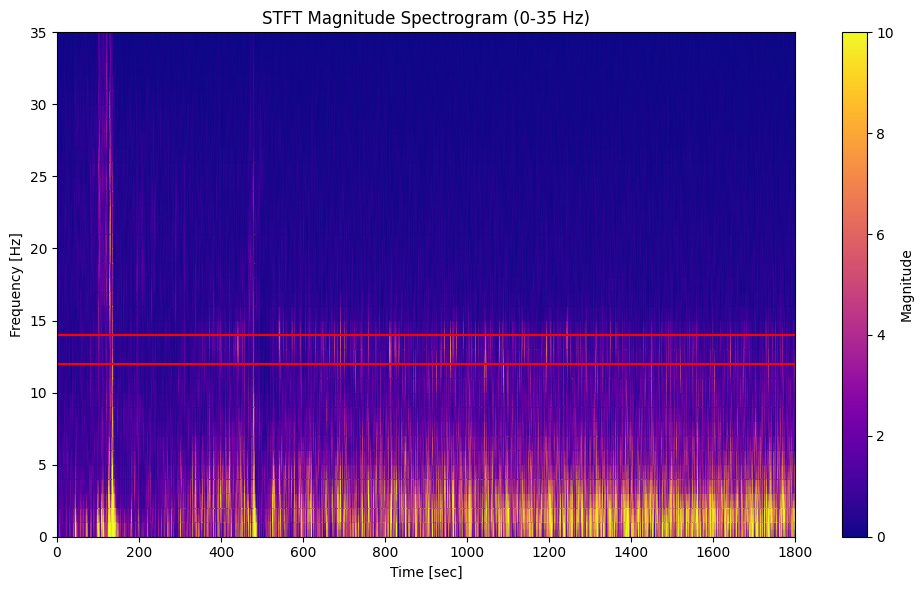

In [16]:
plot_stft(filt_signals[1].y, sampling_freq)

### Testing features

In [17]:
import tqdm
from pathlib import Path
folder = Path("features")

GENERATE = False
data_present = folder.exists()

if GENERATE and not data_present:
    folder.mkdir()
    for i in tqdm.tqdm(range(1, 9)):
        features = generate_features(filt_signals[i])
        features.to_csv(f"features/patient_{i}.csv")

In [18]:
data = {}

if not data_present:
    for i in range(1, 9):
        features = generate_features(filt_signals[i], fs=sampling_freq, verbose=True)
        data[i] = append_detections(features, detections_1[i], fs=sampling_freq)
        
        X_test, y_test = data[1].drop("spindle", axis=1), data[1]["spindle"]
        X_train, y_train = data[2].drop("spindle", axis=1), data[2]["spindle"]

        model = RandomForestClassifier(class_weight="balanced").fit(X_train, y_train)
        print(f1_score(y_test, model.predict(X_test)))
        print(f1_score(y_train, model.predict(X_train)))

    import seaborn as sns
    plt.figure(figsize=(20, 20))
    sns.heatmap(data[1].corr(), annot=True)
    plt.show();

## Visual 1

In [19]:
data = {}
for i in range(1, 9):
    data[i] = pd.read_csv(f"features/patient_{i}.csv").drop("Unnamed: 0", axis=1)

In [20]:
data_v1 = {}
for i in data.keys():
    data_v1[i] = append_detections(data[i].copy(), detections_1[i], fs=sampling_freq)

In [21]:
data_v1.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [22]:
pd.concat([data_v1[i].spindle.value_counts() for i in detections_1.keys()], axis=1)

,spindle,spindle,spindle,spindle,spindle,spindle,spindle,spindle
0,9515,9124,9830,8323,9432,9325,9737,9563
1,427,458,46,477,400,540,148,416


Patient 1 is considered for evaluation

In [23]:
data_v1.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
def get_split(data, test_patient):
    X_test, y_test = data[test_patient].drop("spindle", axis=1), data[test_patient]["spindle"]
    X_train, y_train = pd.concat([data[i].drop("spindle", axis=1) for i in data.keys() if i != test_patient], axis=0), pd.concat([data[i]["spindle"] for i in data.keys() if i != test_patient], axis=0)
    return X_train, X_test, y_train, y_test

def apply_sampling(X_train, y_train):
    rus = RandomUnderSampler(random_state=0)
    X_resampled_under, y_resampled_under = rus.fit_resample(X_train, y_train)
    ros = RandomOverSampler(random_state=0)
    X_resampled_over, y_resampled_over = ros.fit_resample(X_train, y_train)
    return (X_resampled_under, y_resampled_under), (X_resampled_over, y_resampled_over)

X_train, X_test, y_train, y_test = get_split(data_v1, test_patient=1)
(X_resampled_under, y_resampled_under), (X_resampled_over, y_resampled_over) = apply_sampling(X_train, y_train)

In [25]:
def train_models(X_train, y_train, description):
    models = {}
    models['Random Forest'] = RandomForestClassifier(class_weight="balanced", max_depth=10)
    models['Random Forest'].fit(X_train, y_train)

    models['KNN'] = KNeighborsClassifier(weights='distance', 
                                         n_neighbors=30)
    models['KNN'].fit(X_train, y_train)

    neg_to_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    models['XGBoost'] = XGBClassifier(scale_pos_weight=neg_to_pos_ratio,
                                      max_depth=3)
    models['XGBoost'].fit(X_train, y_train)

    return models

In [26]:
def evaluate_models(models, X_test, y_test):
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\nMetrics for {model_name}:")
        print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["Negative", "Positive"], 
                    yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()

In [27]:
models_original = train_models(X_train, y_train, "original")
models_undersampled = train_models(X_resampled_under, y_resampled_under, "undersampled")
models_oversampled = train_models(X_resampled_over, y_resampled_over, "oversampled")

## Train metrics visual 1

Evaluating training on original data:

Metrics for Random Forest:
Balanced Accuracy: 0.9385
Precision: 0.4342
Recall: 0.9227
F1 Score: 0.5905


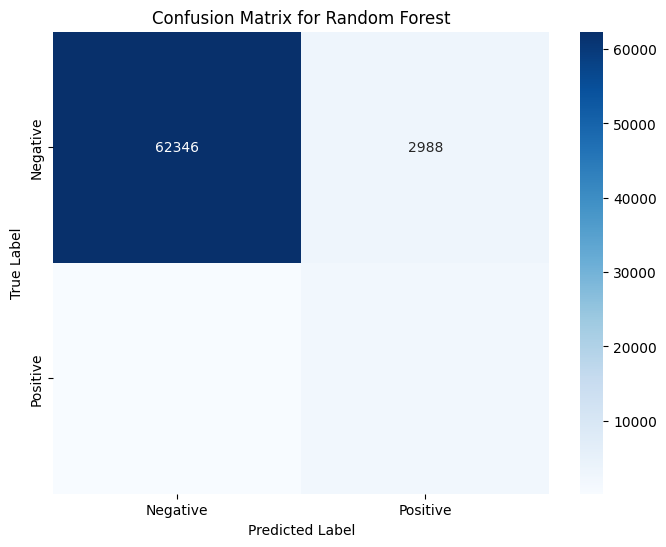


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


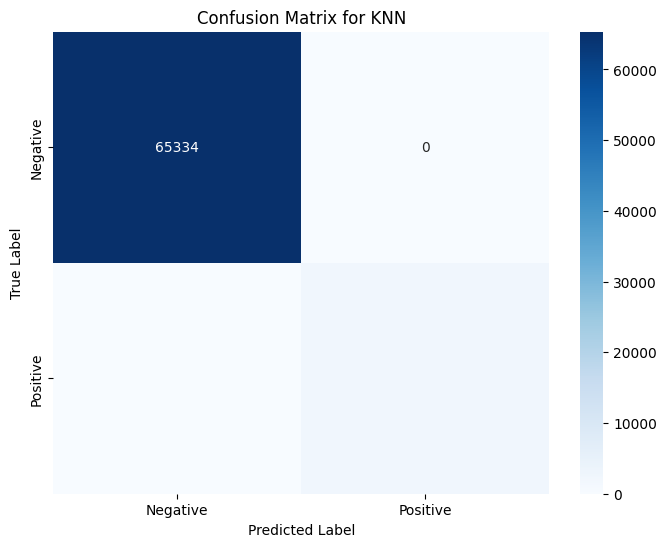


Metrics for XGBoost:
Balanced Accuracy: 0.9317
Precision: 0.3068
Recall: 0.9445
F1 Score: 0.4632


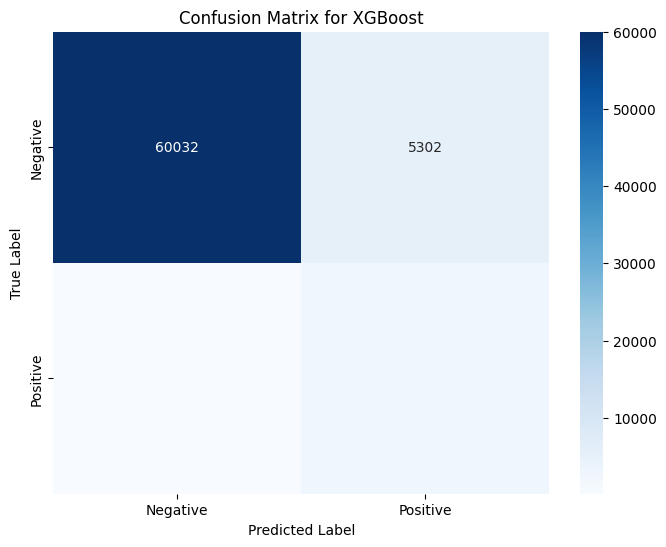

Evaluating training on undersampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.9634
Precision: 0.9656
Recall: 0.9610
F1 Score: 0.9633


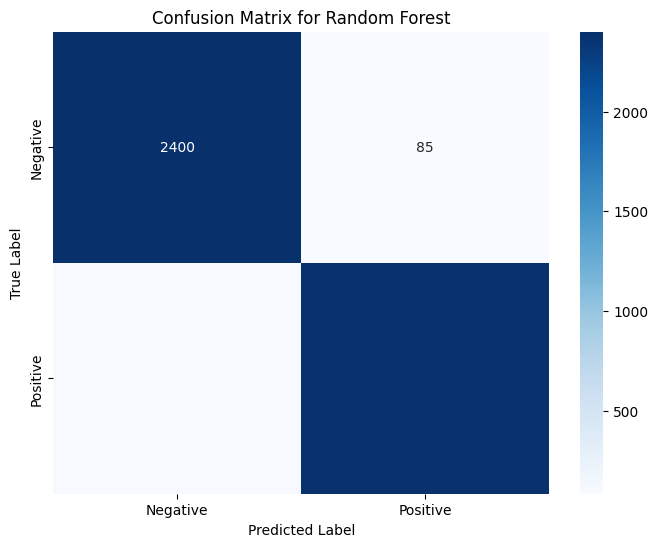


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


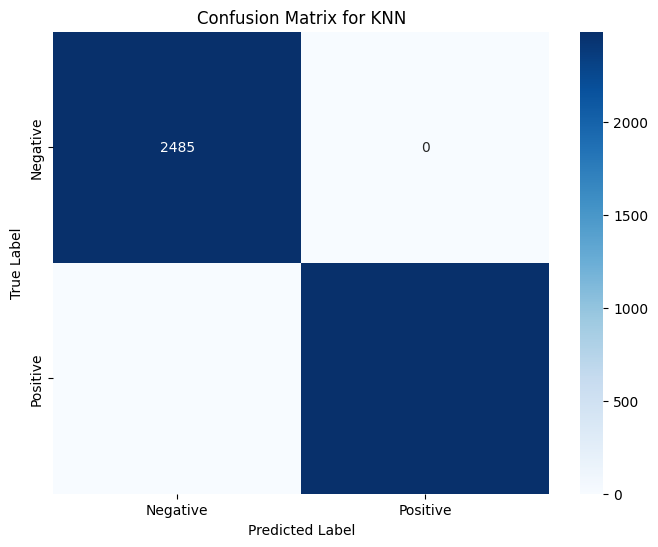


Metrics for XGBoost:
Balanced Accuracy: 0.9475
Precision: 0.9466
Recall: 0.9485
F1 Score: 0.9475


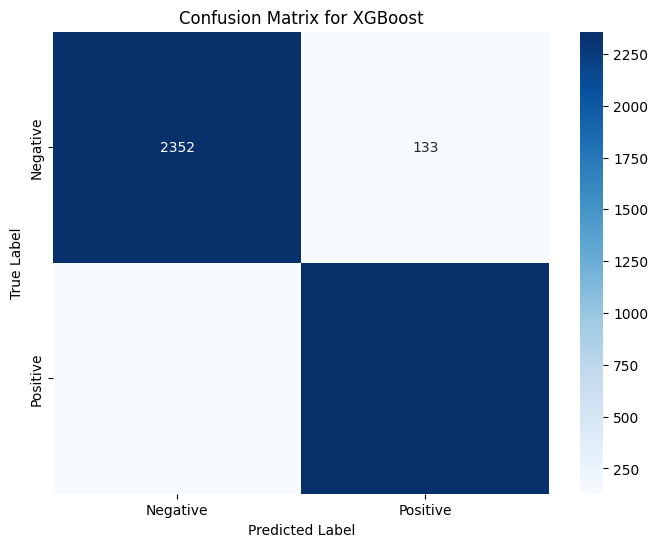

Evaluating training on oversampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.9551
Precision: 0.9448
Recall: 0.9668
F1 Score: 0.9556


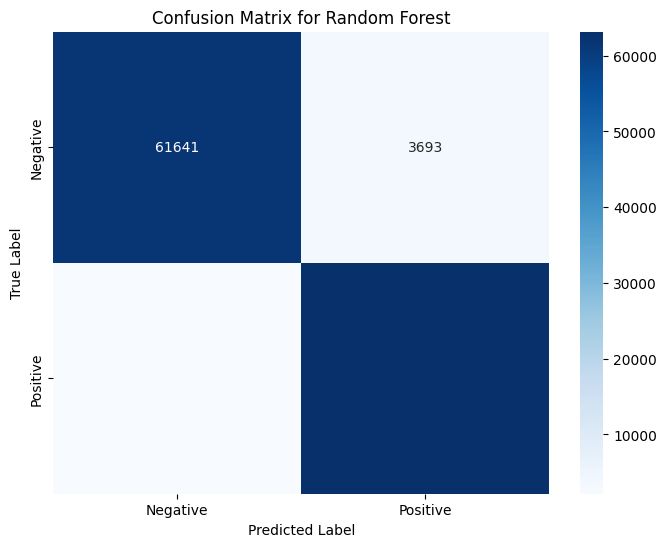


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


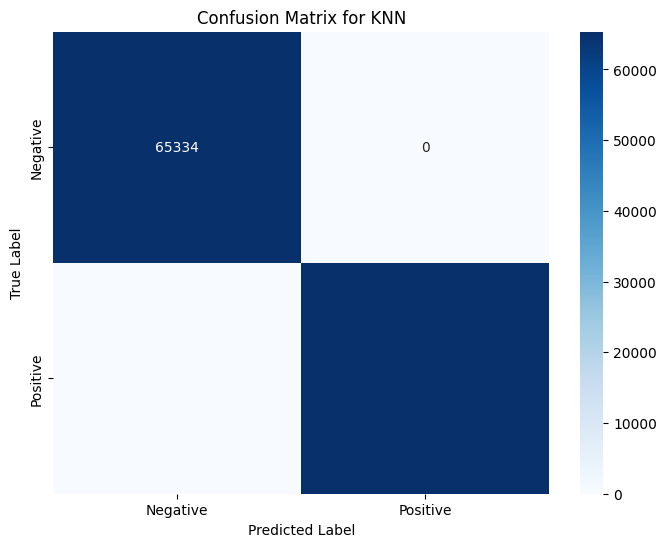


Metrics for XGBoost:
Balanced Accuracy: 0.9325
Precision: 0.9231
Recall: 0.9435
F1 Score: 0.9332


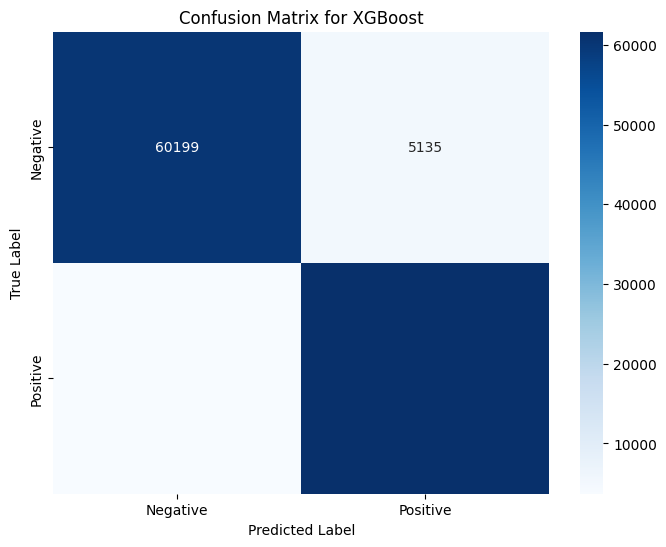

In [28]:
print("Evaluating training on original data:")
evaluate_models(models_original, X_train, y_train)
print("Evaluating training on undersampled data:")
evaluate_models(models_undersampled, X_resampled_under, y_resampled_under)
print("Evaluating training on oversampled data:")
evaluate_models(models_oversampled, X_resampled_over, y_resampled_over)

## Test metrics visual 1

Evaluating models trained on original data:

Metrics for Random Forest:
Balanced Accuracy: 0.8796
Precision: 0.3869
Recall: 0.8173
F1 Score: 0.5252


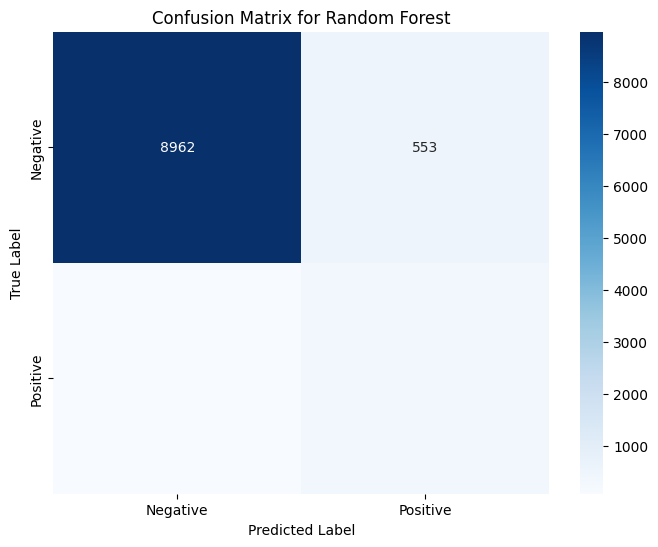


Metrics for KNN:
Balanced Accuracy: 0.5484
Precision: 0.7368
Recall: 0.0984
F1 Score: 0.1736


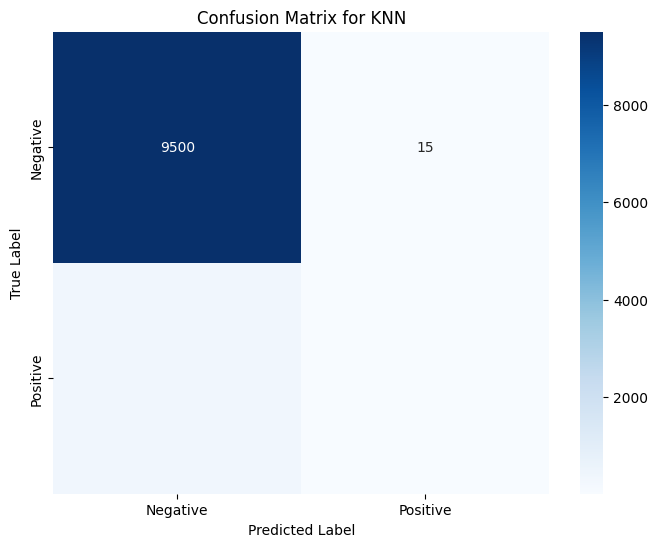


Metrics for XGBoost:
Balanced Accuracy: 0.8940
Precision: 0.2858
Recall: 0.8876
F1 Score: 0.4324


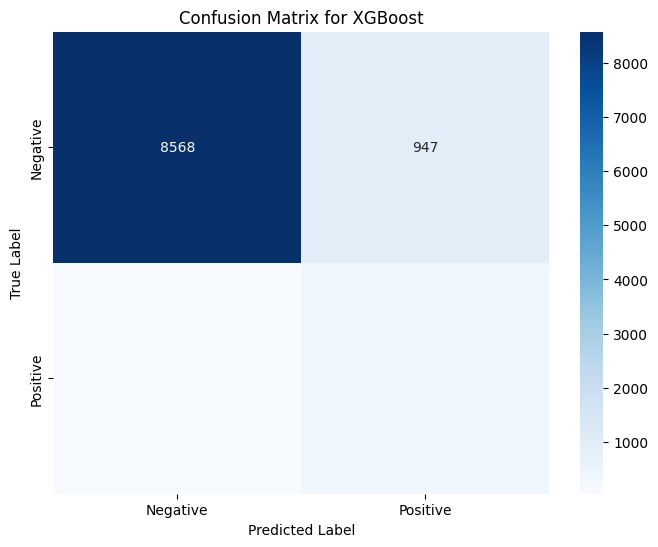

Evaluating models trained on undersampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.9005
Precision: 0.2477
Recall: 0.9274
F1 Score: 0.3909


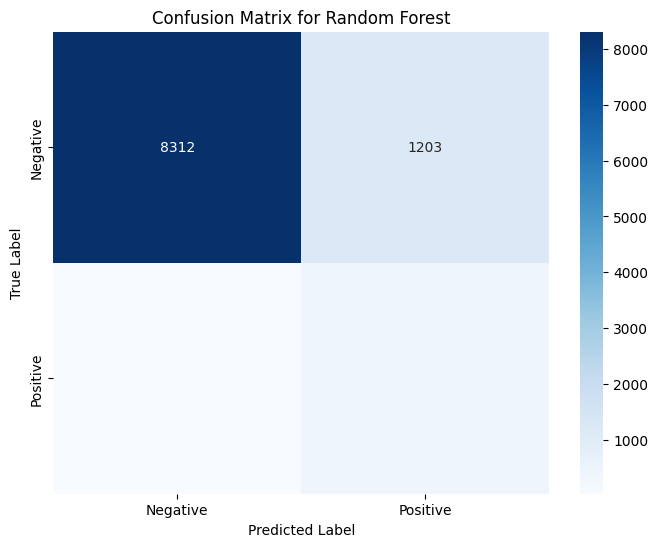


Metrics for KNN:
Balanced Accuracy: 0.6354
Precision: 0.0818
Recall: 0.5457
F1 Score: 0.1422


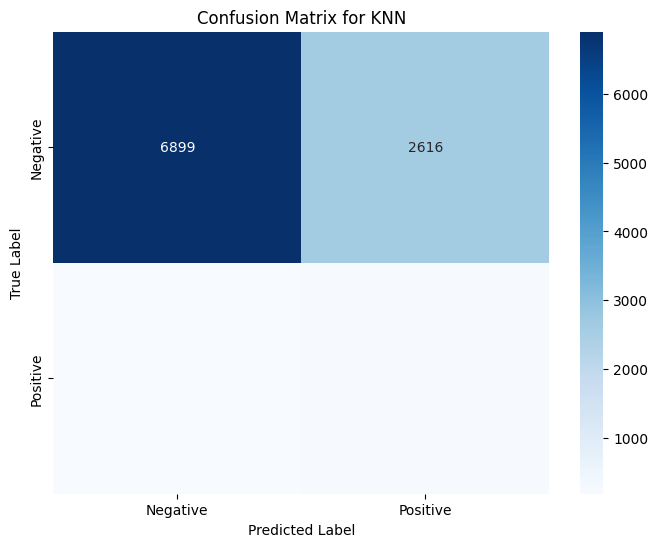


Metrics for XGBoost:
Balanced Accuracy: 0.8923
Precision: 0.2415
Recall: 0.9133
F1 Score: 0.3820


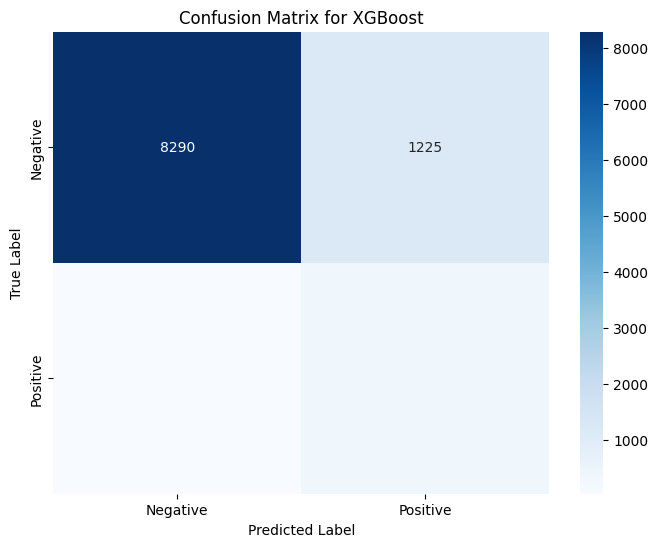

Evaluating models trained on oversampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.8864
Precision: 0.3569
Recall: 0.8407
F1 Score: 0.5010


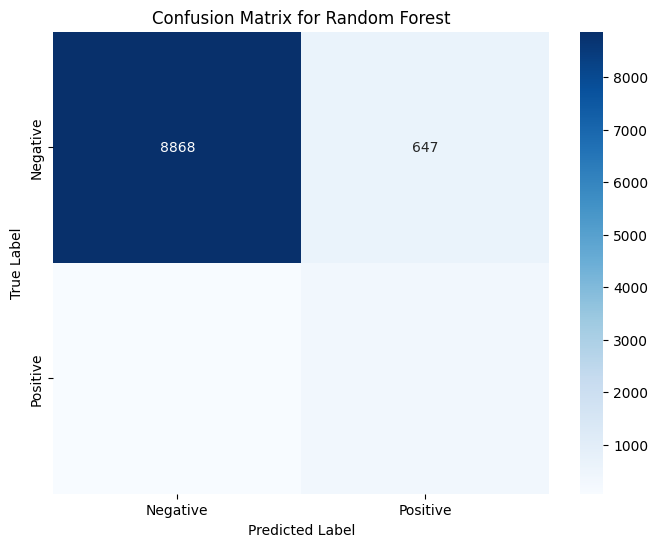


Metrics for KNN:
Balanced Accuracy: 0.6952
Precision: 0.1213
Recall: 0.5785
F1 Score: 0.2006


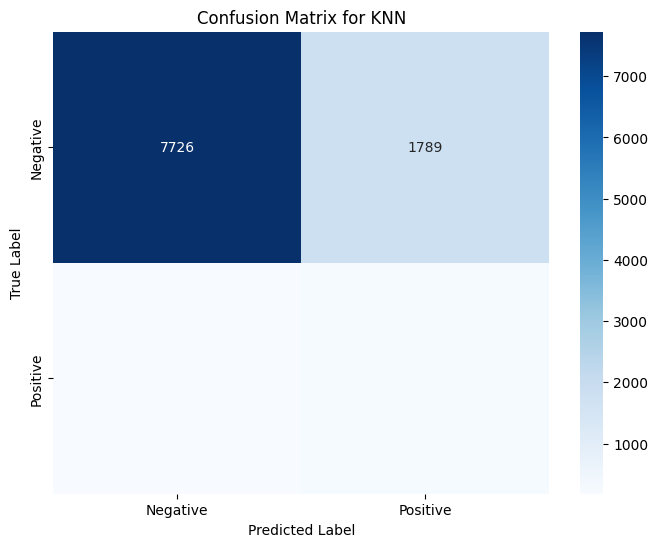


Metrics for XGBoost:
Balanced Accuracy: 0.8854
Precision: 0.2891
Recall: 0.8665
F1 Score: 0.4335


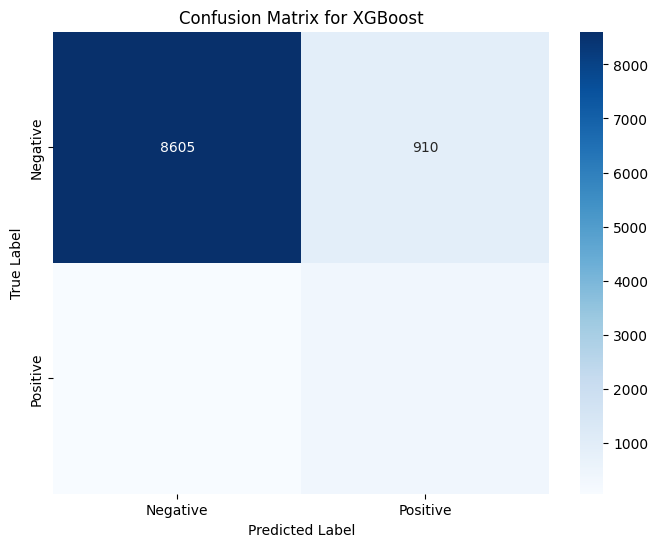

In [29]:
print("Evaluating models trained on original data:")
evaluate_models(models_original, X_test, y_test)
print("Evaluating models trained on undersampled data:")
evaluate_models(models_undersampled, X_test, y_test)
print("Evaluating models trained on oversampled data:")
evaluate_models(models_oversampled, X_test, y_test)

## Visual 2

In [30]:
data_v2 = {}
for i in detections_2.keys():
    data_v2[i] = append_detections(data[i].copy(), detections_2[i], fs=sampling_freq)

In [31]:
data_v2.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [32]:
X_train, X_test, y_train, y_test = get_split(data_v2, test_patient=1)
(X_resampled_under, y_resampled_under), (X_resampled_over, y_resampled_over) = apply_sampling(X_train, y_train)

In [33]:
models_original_2 = train_models(X_train, y_train, "original")
models_undersampled_2 = train_models(X_resampled_under, y_resampled_under, "undersampled")
models_oversampled_2 = train_models(X_resampled_over, y_resampled_over, "oversampled")

## Train metrics visual 2

Evaluating training on original data:

Metrics for Random Forest:
Balanced Accuracy: 0.9244
Precision: 0.3849
Recall: 0.8990
F1 Score: 0.5390


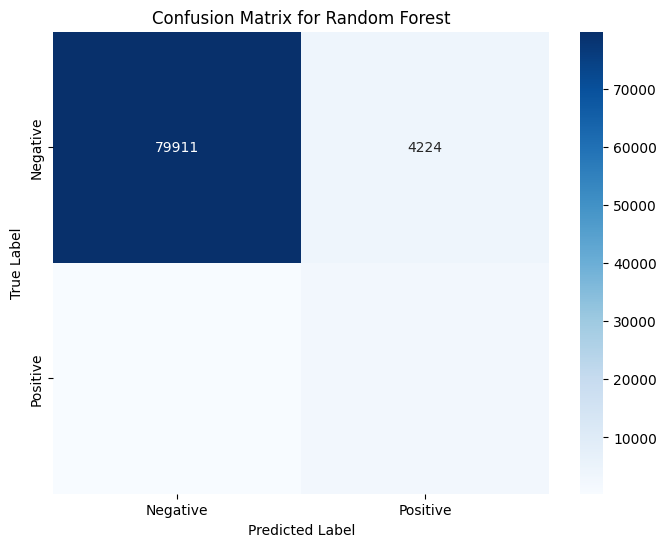


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


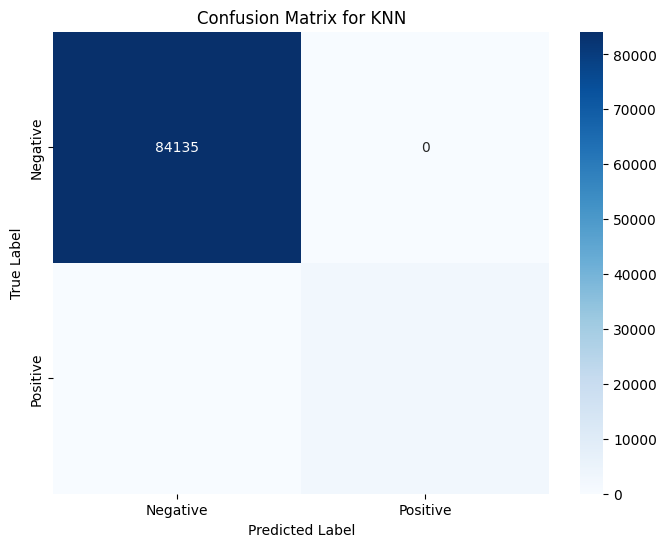


Metrics for XGBoost:
Balanced Accuracy: 0.9151
Precision: 0.2683
Recall: 0.9177
F1 Score: 0.4152


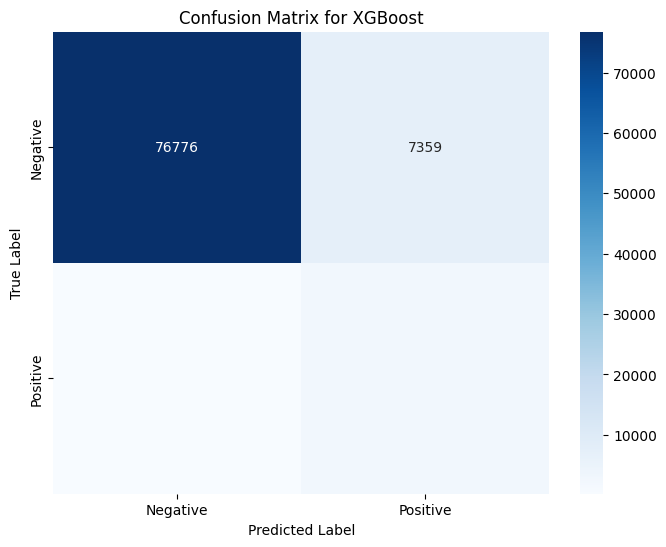

Evaluating training on undersampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.9423
Precision: 0.9584
Recall: 0.9248
F1 Score: 0.9413


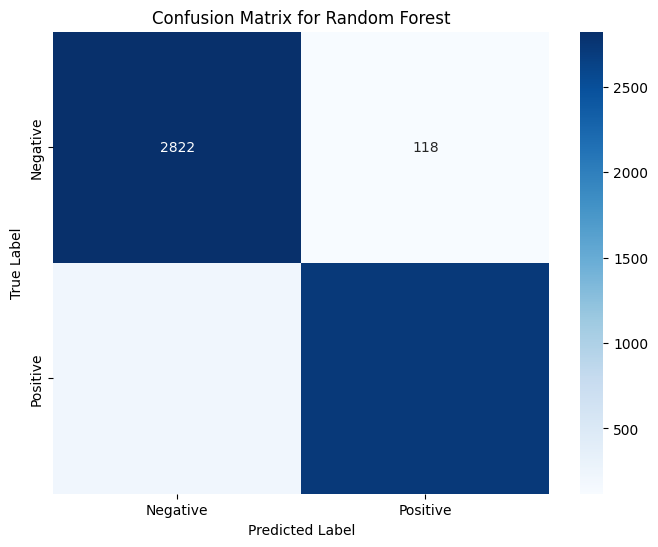


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


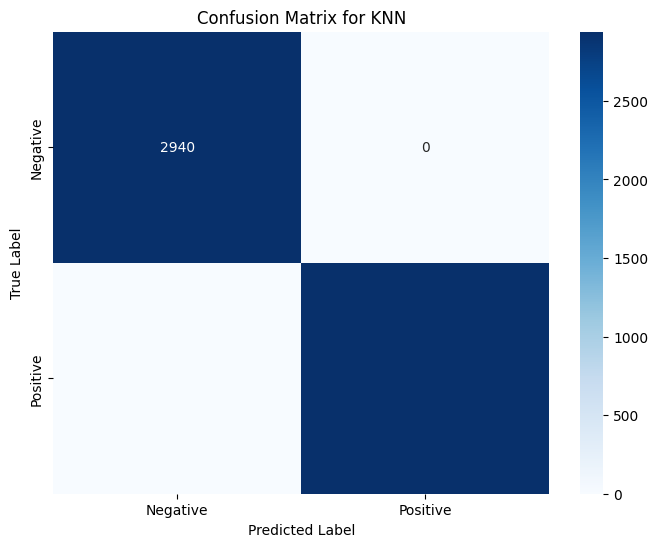


Metrics for XGBoost:
Balanced Accuracy: 0.9252
Precision: 0.9325
Recall: 0.9167
F1 Score: 0.9245


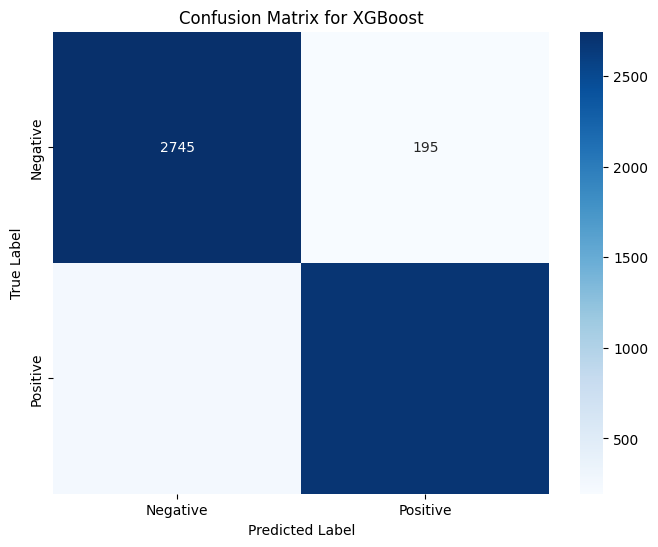

Evaluating training on oversampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.9350
Precision: 0.9388
Recall: 0.9306
F1 Score: 0.9347


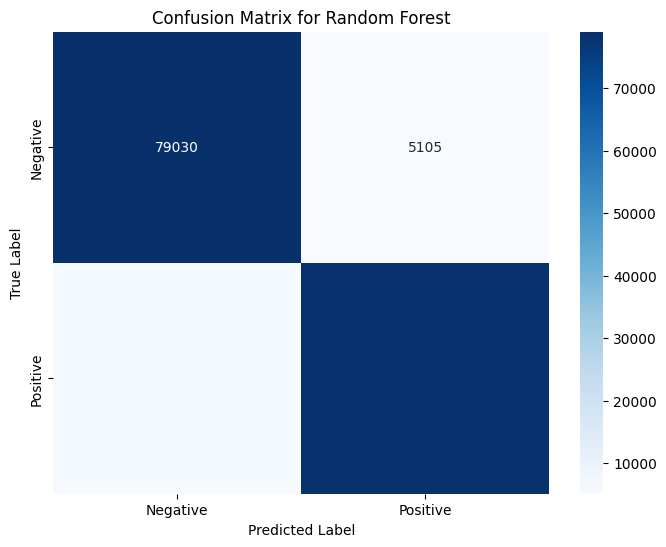


Metrics for KNN:
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


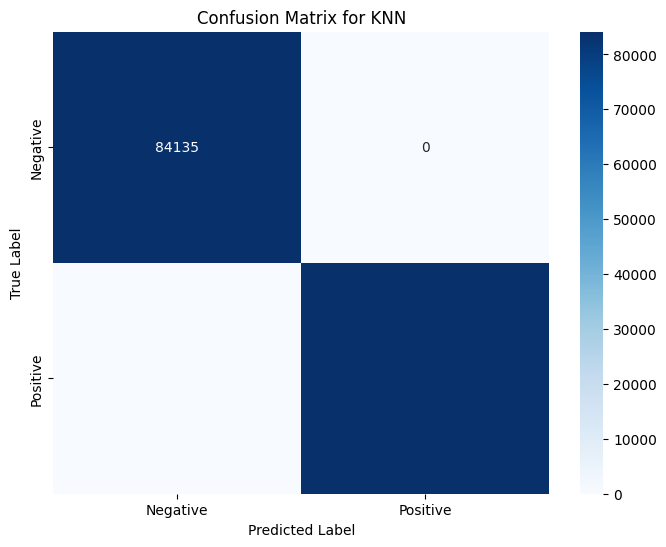


Metrics for XGBoost:
Balanced Accuracy: 0.9129
Precision: 0.9124
Recall: 0.9135
F1 Score: 0.9129


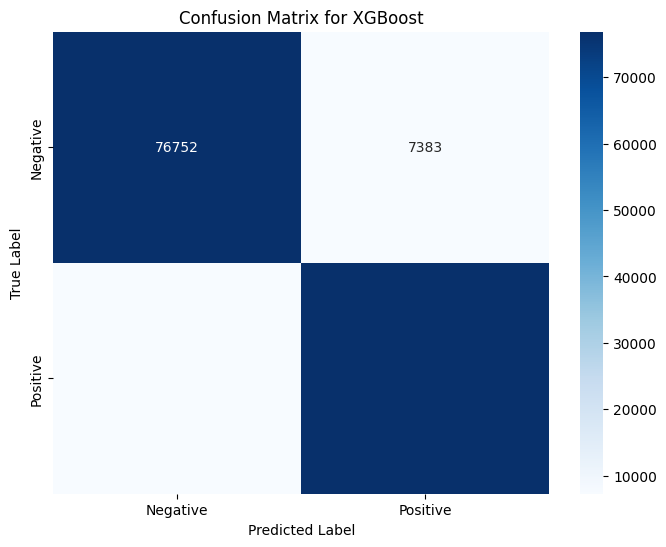

In [34]:
print("Evaluating training on original data:")
evaluate_models(models_original_2, X_train, y_train)
print("Evaluating training on undersampled data:")
evaluate_models(models_undersampled_2, X_resampled_under, y_resampled_under)
print("Evaluating training on oversampled data:")
evaluate_models(models_oversampled_2, X_resampled_over, y_resampled_over)

# Test metrics visual 2

Evaluating models trained on original data:

Metrics for Random Forest:
Balanced Accuracy: 0.8313
Precision: 0.3600
Recall: 0.7544
F1 Score: 0.4874


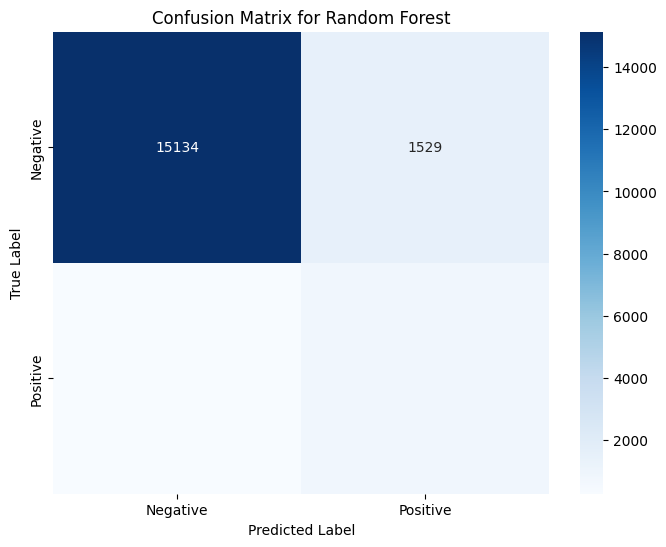


Metrics for KNN:
Balanced Accuracy: 0.5008
Precision: 0.6667
Recall: 0.0018
F1 Score: 0.0035


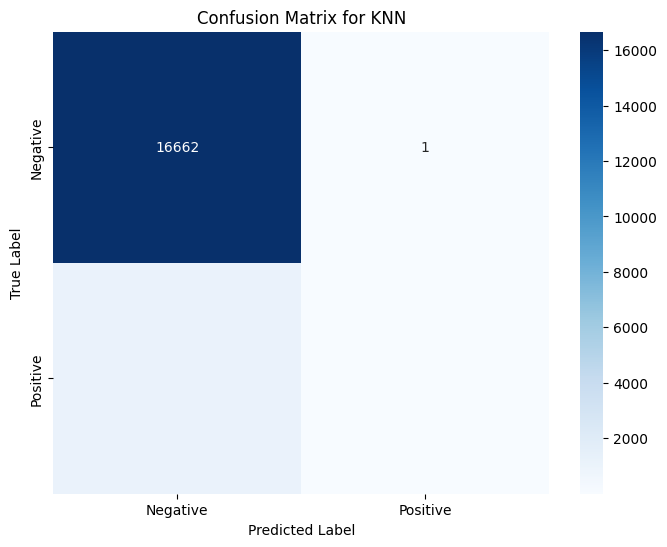


Metrics for XGBoost:
Balanced Accuracy: 0.8319
Precision: 0.2835
Recall: 0.8026
F1 Score: 0.4191


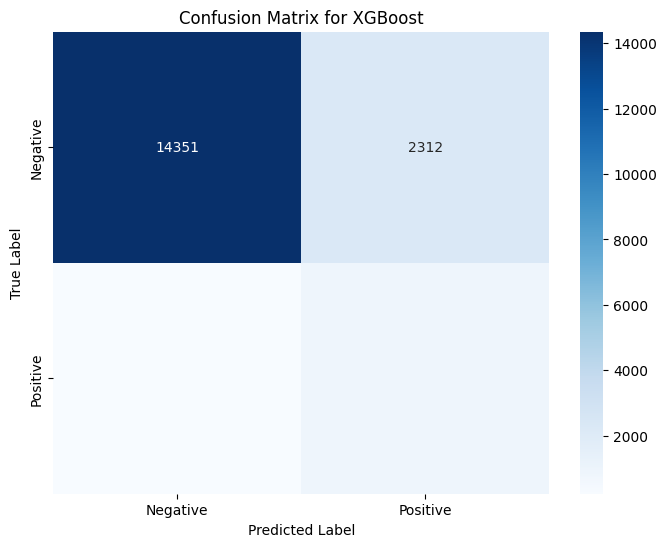

Evaluating models trained on undersampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.8363
Precision: 0.2536
Recall: 0.8421
F1 Score: 0.3898


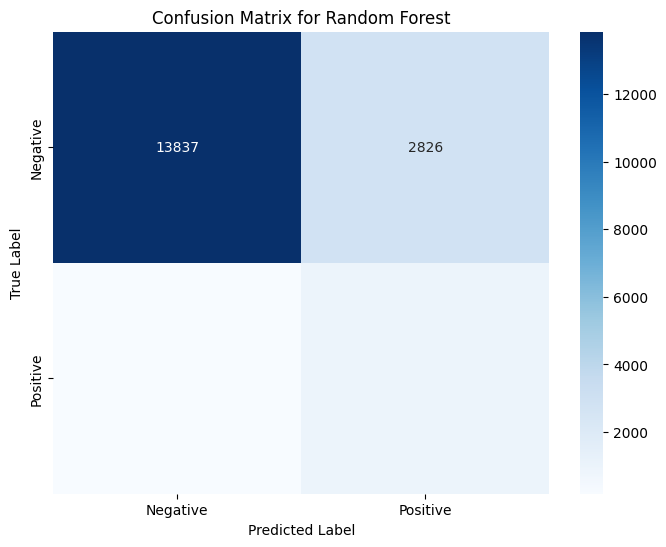


Metrics for KNN:
Balanced Accuracy: 0.6499
Precision: 0.1171
Recall: 0.6193
F1 Score: 0.1970


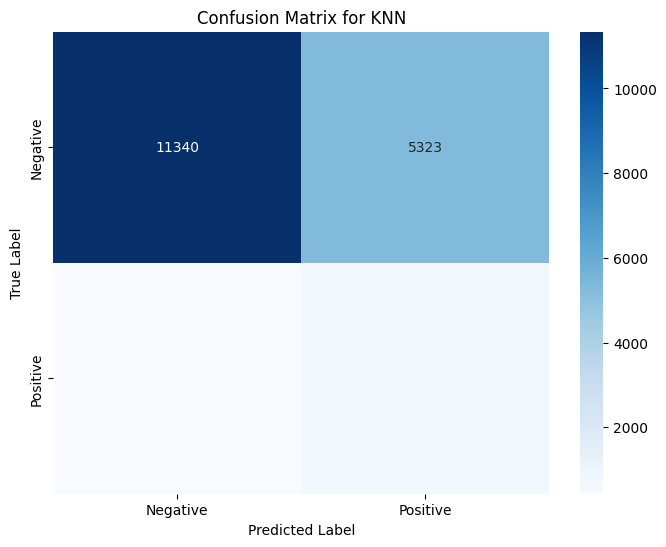


Metrics for XGBoost:
Balanced Accuracy: 0.8299
Precision: 0.2444
Recall: 0.8368
F1 Score: 0.3783


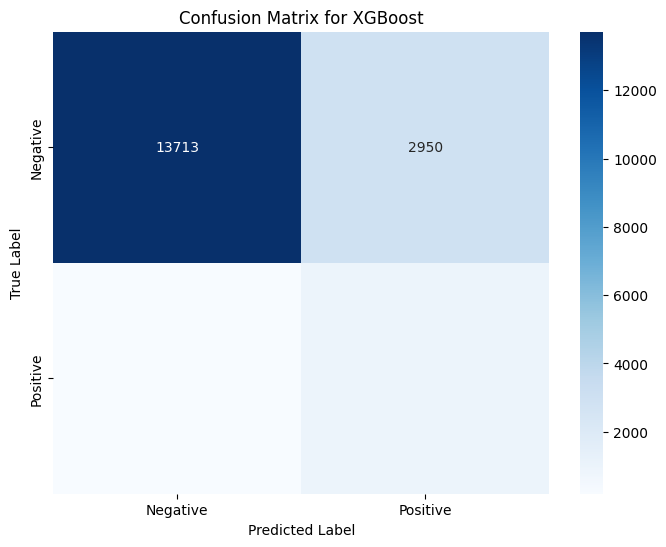

Evaluating models trained on oversampled data:

Metrics for Random Forest:
Balanced Accuracy: 0.8340
Precision: 0.3273
Recall: 0.7772
F1 Score: 0.4606


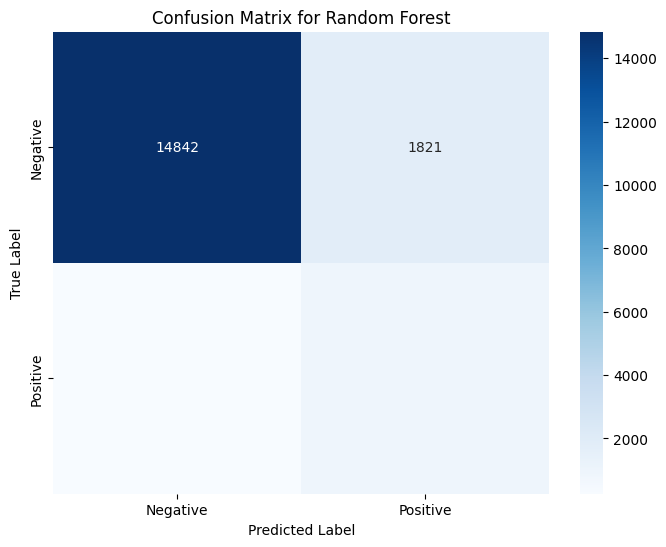


Metrics for KNN:
Balanced Accuracy: 0.6469
Precision: 0.1475
Recall: 0.4860
F1 Score: 0.2263


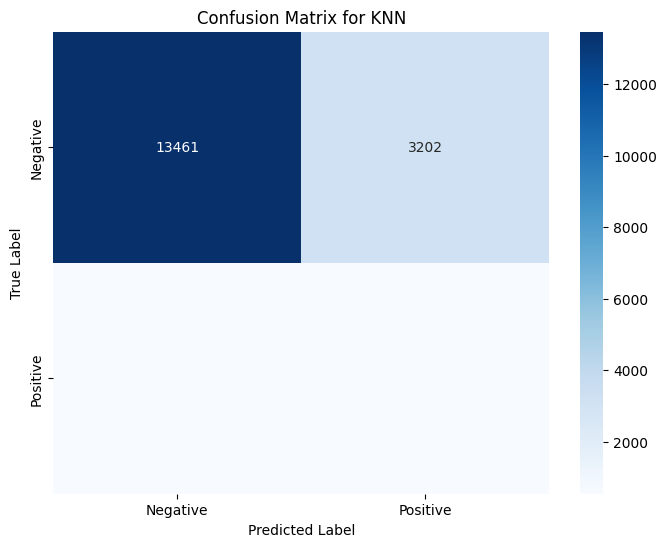


Metrics for XGBoost:
Balanced Accuracy: 0.8303
Precision: 0.2818
Recall: 0.8000
F1 Score: 0.4168


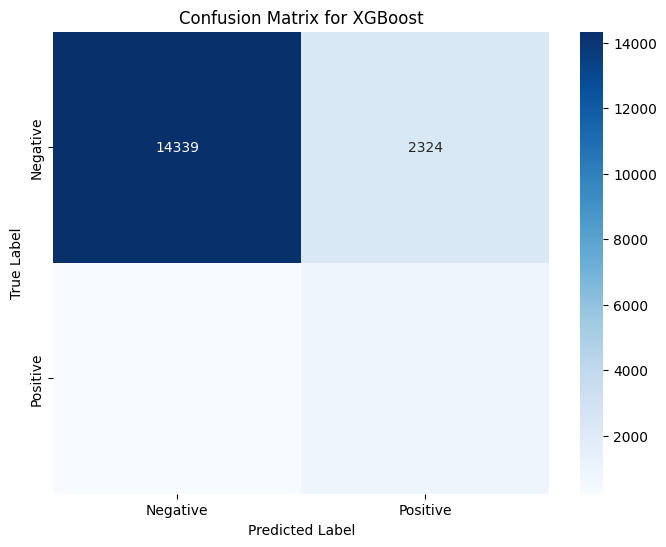

In [35]:
print("Evaluating models trained on original data:")
evaluate_models(models_original_2, X_test, y_test)
print("Evaluating models trained on undersampled data:")
evaluate_models(models_undersampled_2, X_test, y_test)
print("Evaluating models trained on oversampled data:")
evaluate_models(models_oversampled_2, X_test, y_test)